In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
from xgcm import Grid
import momlevel as ml
import sectionate

### Use Dask SLURMCluster

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 

portdash=19131

cluster = SLURMCluster(
    queue="analysis",
    cores=4,
    project="gfdl_o",
    job_extra=["-C bigmem"],
    memory="128GB",
    walltime="04:00:00",
    scheduler_options={"dashboard_address":f'{portdash}'},
)

client=Client(cluster)
client

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.208.147.7:19131/status,
Dashboard: http://140.208.147.7:19131/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.208.147.7:37809,Workers: 0
Dashboard: http://140.208.147.7:19131/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.scale(10)

## Load model output for GFDL high-res configurations
#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#### __Odiv-207__: p125, c192. Sensitivity experiment with same sea ice albedos as Odiv-206 but with ESM4 snow-on-land albedos values.

#####
##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [5]:
## There are some issues with the cm4 cmip6 output, so preprocessing is required when reading 
## in the data using xr.open_mfdataset()

def load_ocean(model_config):
    if model_config == 'Odiv-183':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                               combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                               combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-184':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-170':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-191':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-200':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-206':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-207':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-209':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc &')
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'cmip6-cm4':
        ds_u = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/*uo.nc',
                               combine='by_coords',use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/*umo.nc',
                               combine='by_coords',use_cftime=True)
    
    return ds_u, ds_umo


def annual_mean(array):
    """
    weight by days in each month
    """
    # Determine month length
    month_length = array.time.dt.days_in_month
    # Calculate weights
    wgts = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Setup our masking for nan values
    cond = array.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    array_sum = (array * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return array_sum / ones_out

### Load static fields

In [6]:
static_om4p125 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')
static_om4p25 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')

### Load om4p125 configurations

In [7]:
odiv_183_u = load_ocean('Odiv-183')[0]
odiv_184_u = load_ocean('Odiv-184')[0]
odiv_183_184_u = xr.concat([odiv_183_u,odiv_184_u],dim='time').sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})

odiv_200_u = load_ocean('Odiv-200')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_206_u = load_ocean('Odiv-206')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_207_u = load_ocean('Odiv-207')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_209_u = load_ocean('Odiv-209')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})

odiv_183_umo = load_ocean('Odiv-183')[1]
odiv_184_umo = load_ocean('Odiv-184')[1]
odiv_183_184_umo = xr.concat([odiv_183_umo,odiv_184_umo],dim='time').sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})

odiv_200_umo = load_ocean('Odiv-200')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_206_umo = load_ocean('Odiv-206')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_207_umo = load_ocean('Odiv-207')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_209_umo = load_ocean('Odiv-209')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})

In [8]:
## Load om4p25 configurations:
odiv_170_u = load_ocean('Odiv-170')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
odiv_170_umo = load_ocean('Odiv-170')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
cm4_cmip6_u = load_ocean('cmip6-cm4')[0].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})
cm4_cmip6_umo = load_ocean('cmip6-cm4')[1].sel(yh=slice(-90,-50)).chunk({'time':20,'xq':288,'yh':126})

## Use sectionate to find the cross sections for each model configuration

In [9]:
## Use sectionate to find the cross section closest to 20E for each model configuration
## 20E
lat20e_coast = -70.5
lon20e_coast = 20
lat20e_offshore = -68
lon20e_offshore = 20
## 150E
lat150e_coast = -69
lon150e_coast = -210
lat150e_offshore = -65.2
lon150e_offshore = -210
## 130W
lat130w_coast = -75
lon130w_coast = -130
lat130w_offshore = -72
lon130w_offshore = -130
## 80W
lat80w_coast = -74
lon80w_coast = -80
lat80w_offshore = -68
lon80w_offshore = -80

isec_20e_p125, jsec_20e_p125, xsec_20e_p125, ysec_20e_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon20e_coast,lat20e_coast,lon20e_offshore,lat20e_offshore)
isec_150e_p125, jsec_150e_p125, xsec_150e_p125, ysec_150e_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon150e_coast,lat150e_coast,lon150e_offshore,lat150e_offshore)
isec_130w_p125, jsec_130w_p125, xsec_130w_p125, ysec_130w_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon130w_coast,lat130w_coast,lon130w_offshore,lat130w_offshore)
isec_80w_p125, jsec_80w_p125, xsec_80w_p125, ysec_80w_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon80w_coast,lat80w_coast,lon80w_offshore,lat80w_offshore)

isec_20e_p25, jsec_20e_p25, xsec_20e_p25, ysec_20e_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon20e_coast,lat20e_coast,lon20e_offshore,lat20e_offshore)
isec_150e_p25, jsec_150e_p25, xsec_150e_p25, ysec_150e_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon150e_coast,lat150e_coast,lon150e_offshore,lat150e_offshore)
isec_130w_p25, jsec_130w_p25, xsec_130w_p25, ysec_130w_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon130w_coast,lat130w_coast,lon130w_offshore,lat130w_offshore)
isec_80w_p25, jsec_80w_p25, xsec_80w_p25, ysec_80w_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon80w_coast,lat80w_coast,lon80w_offshore,lat80w_offshore)

In [10]:
### find xq value with point closest to correct longitude
xsec_20e_p125[0].xq.values,\
xsec_150e_p125[0].xq.values,\
xsec_130w_p125[0].xq.values,\
xsec_80w_p125[0].xq.values

(array(24.41054717),
 array(-215.20303921),
 array(-135.07166178),
 array(-76.39249697))

In [11]:
### find xq value with point closest to correct longitude
xsec_20e_p25[0].xq.values,\
xsec_150e_p25[0].xq.values,\
xsec_130w_p25[0].xq.values,\
xsec_80w_p25[0].xq.values

(array(20.50622247),
 array(-210.59139769),
 array(-130.49207101),
 array(-79.65569144))

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(0.99, 0.9, 'Odiv-209')

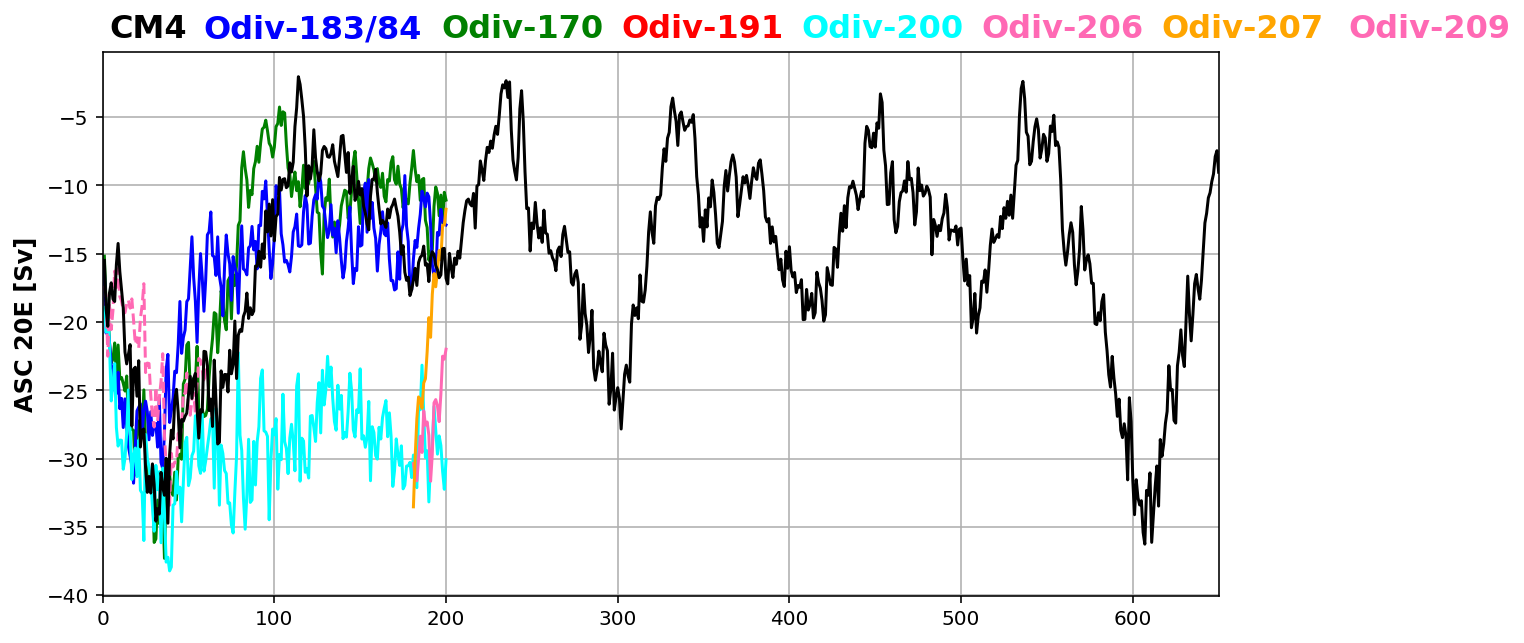

In [12]:
asc_20e_170 = odiv_170_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_183_184 = odiv_183_184_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
#asc_20e_191 = odiv_191_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_200 = odiv_200_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_206 = odiv_206_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_207 = odiv_207_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_209 = odiv_209_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_cmip6 = cm4_cmip6_umo.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(asc_20e_170.time.dt.year,asc_20e_170,color='green')
plt.plot(asc_20e_183_184.time.dt.year,asc_20e_183_184,color='blue')
#plt.plot(asc_20e_191.time.dt.year,asc_20e_191,color='red')
plt.plot(asc_20e_200.time.dt.year,asc_20e_200,color='cyan')
plt.plot(asc_20e_206.time.dt.year,asc_20e_206,color='hotpink')
plt.plot(asc_20e_207.time.dt.year,asc_20e_207,color='orange')
plt.plot(asc_20e_209.time.dt.year,asc_20e_209,color='hotpink',linestyle='--')
plt.plot(asc_20e_cmip6.time.dt.year,asc_20e_cmip6,color='black')

ax.set_ylabel('ASC 20E [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209',fontsize=16,color='hotpink',fontweight='bold')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(0.99, 0.9, 'Odiv-209')

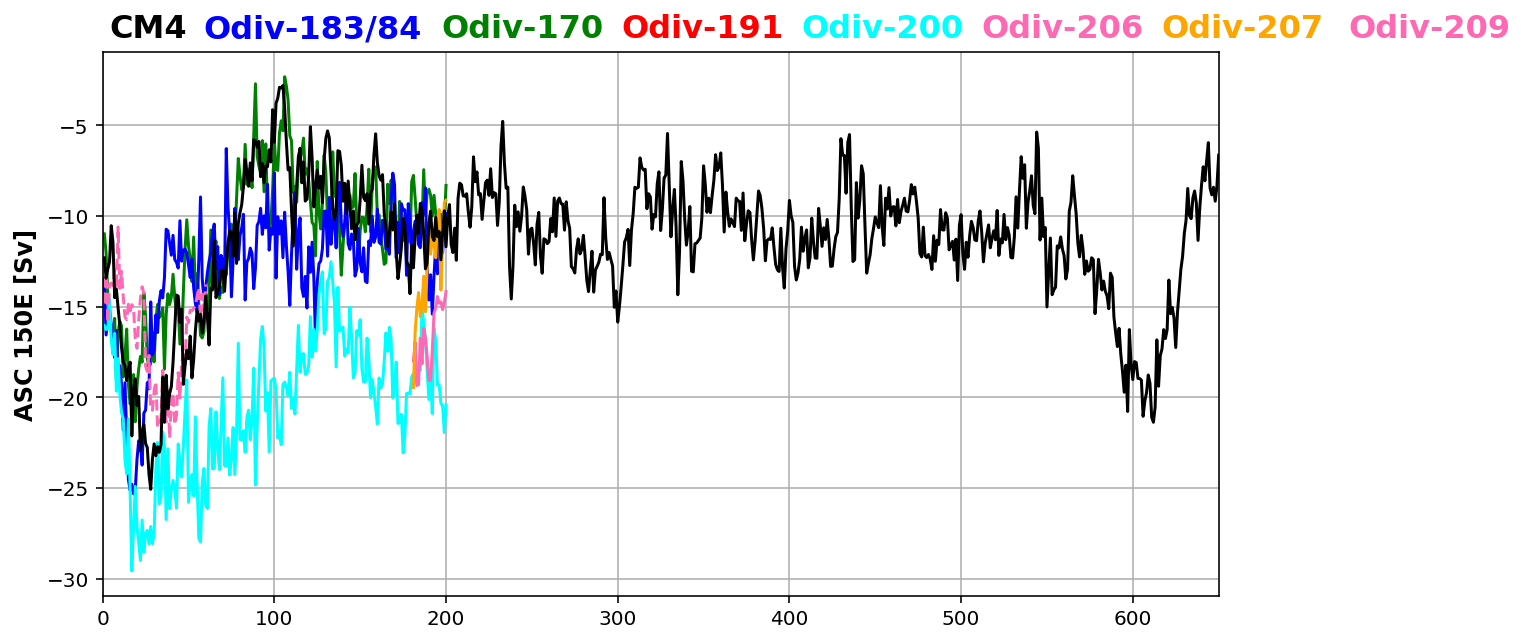

In [13]:
asc_150e_170 = odiv_170_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_183_184 = odiv_183_184_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
#asc_150e_191 = odiv_191_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_200 = odiv_200_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_206 = odiv_206_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_207 = odiv_207_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_209 = odiv_209_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_cmip6 = cm4_cmip6_umo.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6


fig, ax = plt.subplots(figsize=(10,5))


plt.plot(asc_150e_170.time.dt.year,asc_150e_170,color='green')
plt.plot(asc_150e_183_184.time.dt.year,asc_150e_183_184,color='blue')
#plt.plot(asc_150e_191.time.dt.year,asc_150e_191,color='red')
plt.plot(asc_150e_200.time.dt.year,asc_150e_200,color='cyan')
plt.plot(asc_150e_206.time.dt.year,asc_150e_206,color='hotpink')
plt.plot(asc_150e_207.time.dt.year,asc_150e_207,color='orange')
plt.plot(asc_150e_209.time.dt.year,asc_150e_209,color='hotpink',linestyle='--')
plt.plot(asc_150e_cmip6.time.dt.year,asc_150e_cmip6,color='black')

ax.set_ylabel('ASC 150E [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209',fontsize=16,color='hotpink',fontweight='bold')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(0.99, 0.9, 'Odiv-209')

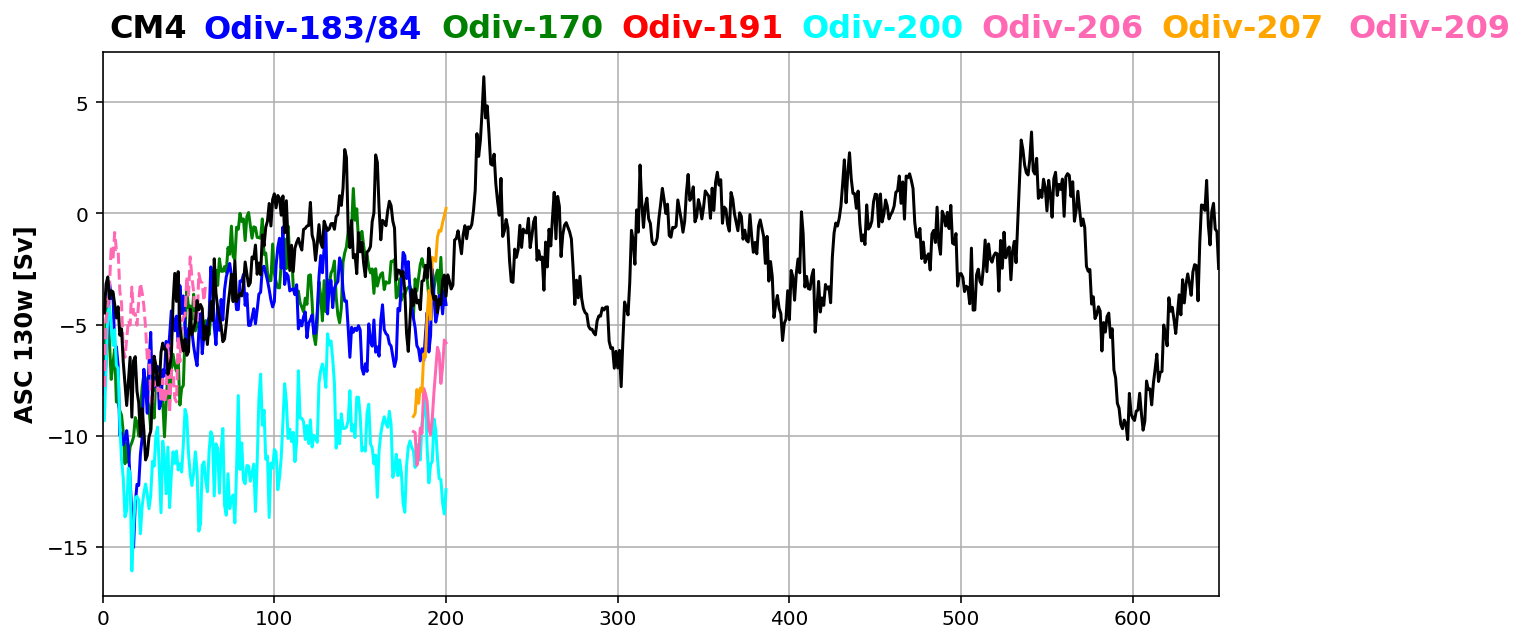

In [14]:
asc_130w_170 = odiv_170_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_183_184 = odiv_183_184_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
#asc_130w_191 = odiv_191.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_200 = odiv_200_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_206 = odiv_206_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_207 = odiv_207_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_209 = odiv_209_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-135,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_cmip6 = cm4_cmip6_umo.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

fig, ax = plt.subplots(figsize=(10,5))


plt.plot(asc_130w_170.time.dt.year,asc_130w_170,color='green')
plt.plot(asc_130w_183_184.time.dt.year,asc_130w_183_184,color='blue')
#plt.plot(asc_130w_191.time.dt.year,asc_130w_191,color='red')
plt.plot(asc_130w_200.time.dt.year,asc_130w_200,color='cyan')
plt.plot(asc_130w_206.time.dt.year,asc_130w_206,color='hotpink')
plt.plot(asc_130w_207.time.dt.year,asc_130w_207,color='orange')
plt.plot(asc_130w_209.time.dt.year,asc_130w_209,color='hotpink',linestyle='--')
plt.plot(asc_130w_cmip6.time.dt.year,asc_130w_cmip6,color='black')

ax.set_ylabel('ASC 130w [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209',fontsize=16,color='hotpink',fontweight='bold')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(0.99, 0.9, 'Odiv-209')

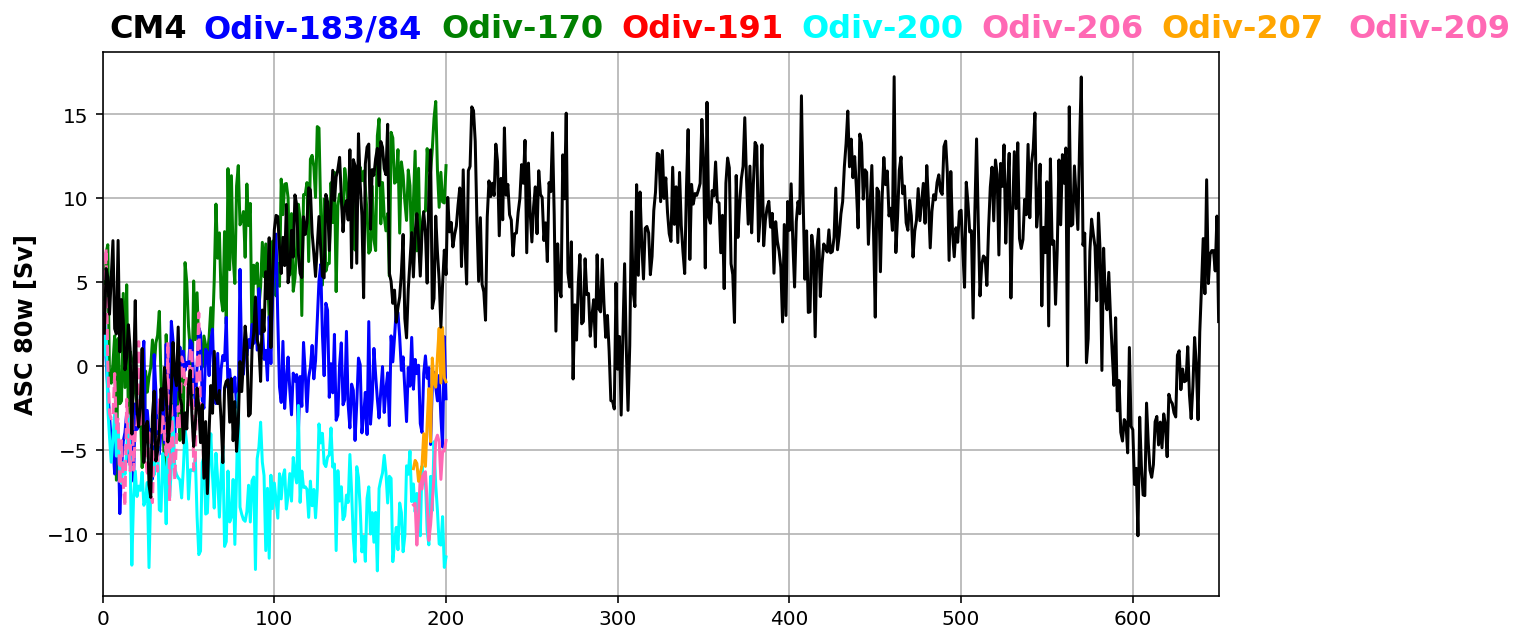

In [15]:
asc_80w_170 = odiv_170_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_183_184 = odiv_183_184_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
#asc_80w_191 = odiv_191.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_200 = odiv_200_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_206 = odiv_206_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_207 = odiv_207_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_209 = odiv_209_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80w_cmip6 = cm4_cmip6_umo.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(asc_80w_170.time.dt.year,asc_80w_170,color='green')
plt.plot(asc_80w_183_184.time.dt.year,asc_80w_183_184,color='blue')
#plt.plot(asc_80w_191.time.dt.year,asc_80w_191,color='red')
plt.plot(asc_80w_200.time.dt.year,asc_80w_200,color='cyan')
plt.plot(asc_80w_206.time.dt.year,asc_80w_206,color='hotpink')
plt.plot(asc_80w_207.time.dt.year,asc_80w_207,color='orange')
plt.plot(asc_80w_209.time.dt.year,asc_80w_209,color='hotpink',linestyle='--')
plt.plot(asc_80w_cmip6.time.dt.year,asc_80w_cmip6,color='black')

ax.set_ylabel('ASC 80w [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209',fontsize=16,color='hotpink',fontweight='bold')

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(635.1517241379311, 0.5, '')

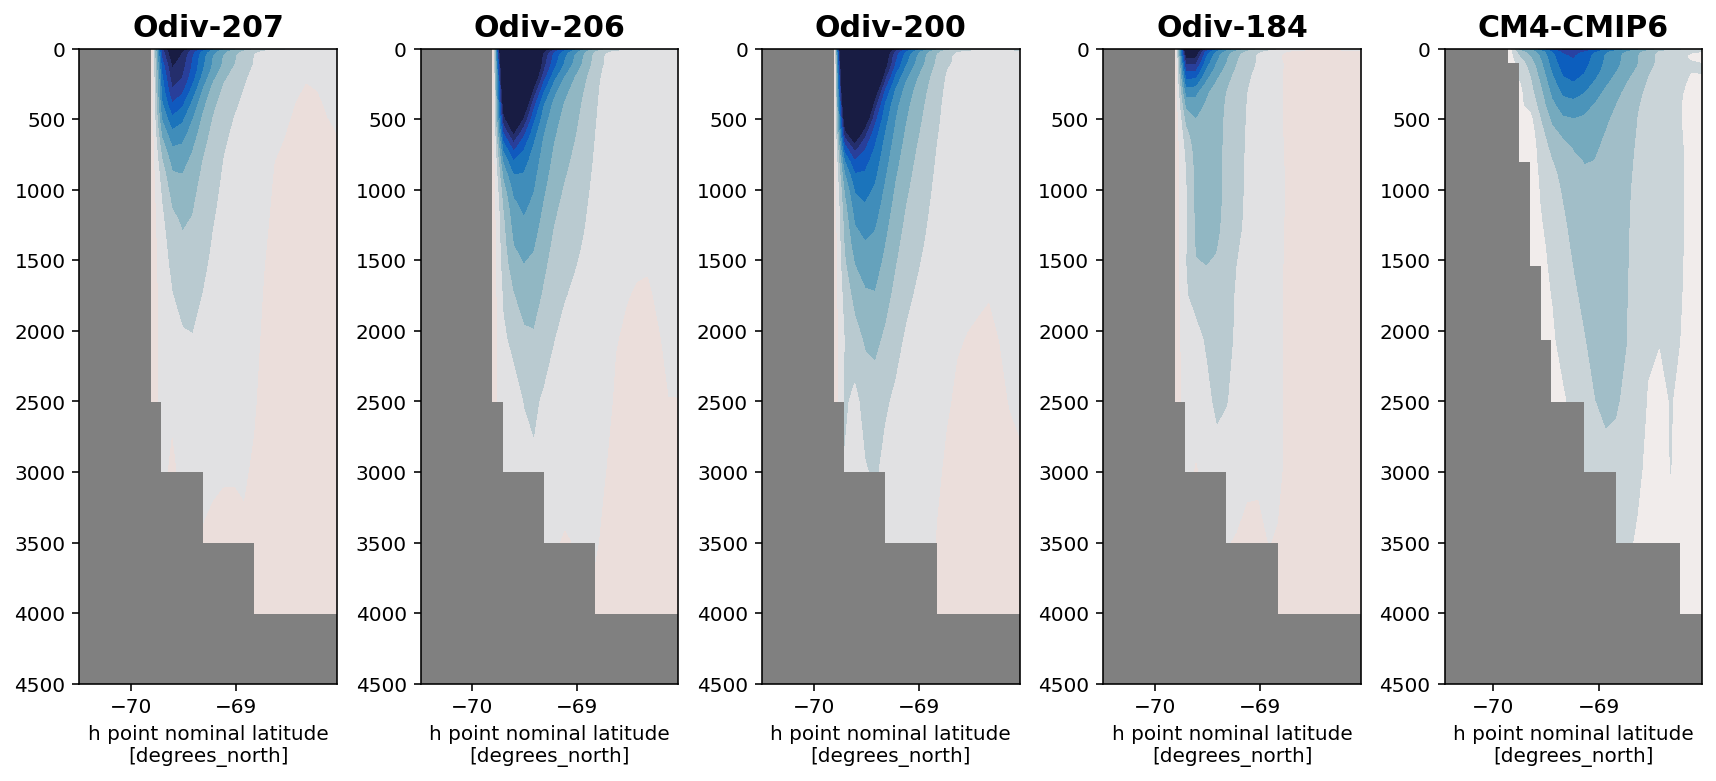

In [28]:
### Velocity at all cross-sections:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(12,5),subplot_kw=dict(facecolor='grey'))
plt.tight_layout()


levels_vel = np.linspace(-0.16,0.16,20)

odiv_207_u.uo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax1,
                                                                                                                add_colorbar=False,
                                                                                                                corner_mask=False)
odiv_206_u.uo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax2,
                                                                                                                add_colorbar=False,
                                                                                                                corner_mask=False)
odiv_200_u.uo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax3,
                                                                                                                add_colorbar=False,
                                                                                                                corner_mask=False)
odiv_183_184_u.uo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax4,
                                                                                                                add_colorbar=False,
                                                                                                                corner_mask=False)
cm4_cmip6_u.uo.sel(yh=slice(-70.5,-68)).sel(xq=20.36,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax5,
                                                                                                                add_colorbar=False,
                                                                                                                corner_mask=False)
ax1.set_title("Odiv-207",fontsize=15, fontweight='bold')
ax2.set_title("Odiv-206",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-200",fontsize=15, fontweight='bold')
ax4.set_title("Odiv-184",fontsize=15, fontweight='bold')
ax5.set_title("CM4-CMIP6",fontsize=15, fontweight='bold')

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(635.1517241379311, 0.5, '')

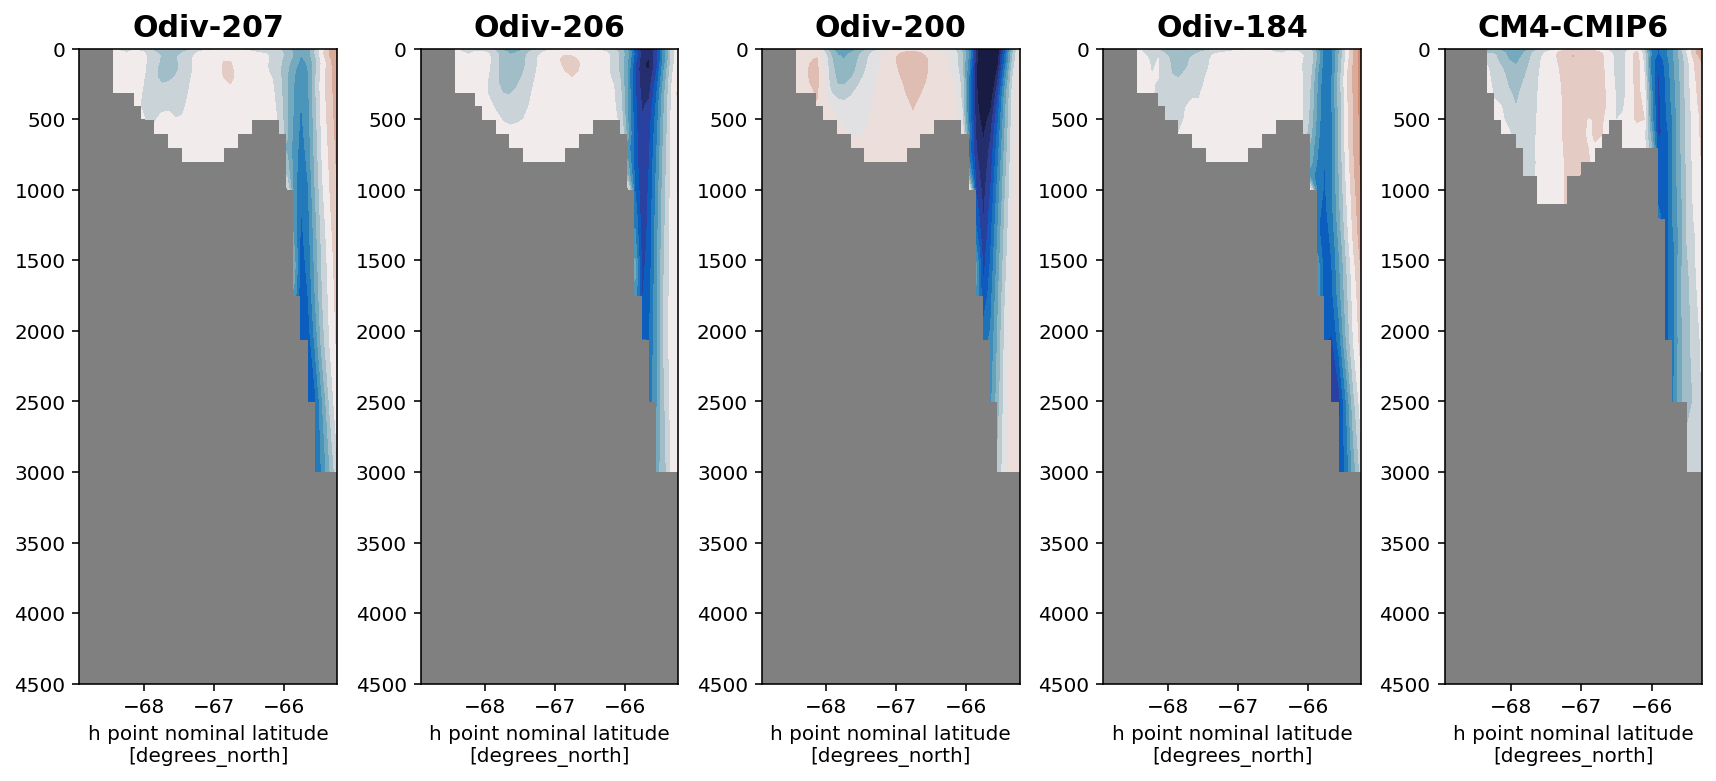

In [31]:
### Velocity at all cross-sections:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(12,5),subplot_kw=dict(facecolor='grey'))
plt.tight_layout()


levels_vel = np.linspace(-0.16,0.16,20)

odiv_207_u.uo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax1,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_206_u.uo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax2,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_200_u.uo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax3,
                                                                                                                add_colorbar=False, corner_mask=False)

odiv_183_184_u.uo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax4,
                                                                                                                add_colorbar=False, corner_mask=False)

cm4_cmip6_u.uo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax5,
                                                                                                                add_colorbar=False, corner_mask=False)
ax1.set_title("Odiv-207",fontsize=15, fontweight='bold')
ax2.set_title("Odiv-206",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-200",fontsize=15, fontweight='bold')
ax4.set_title("Odiv-184",fontsize=15, fontweight='bold')
ax5.set_title("CM4-CMIP6",fontsize=15, fontweight='bold')

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(635.1517241379311, 0.5, '')

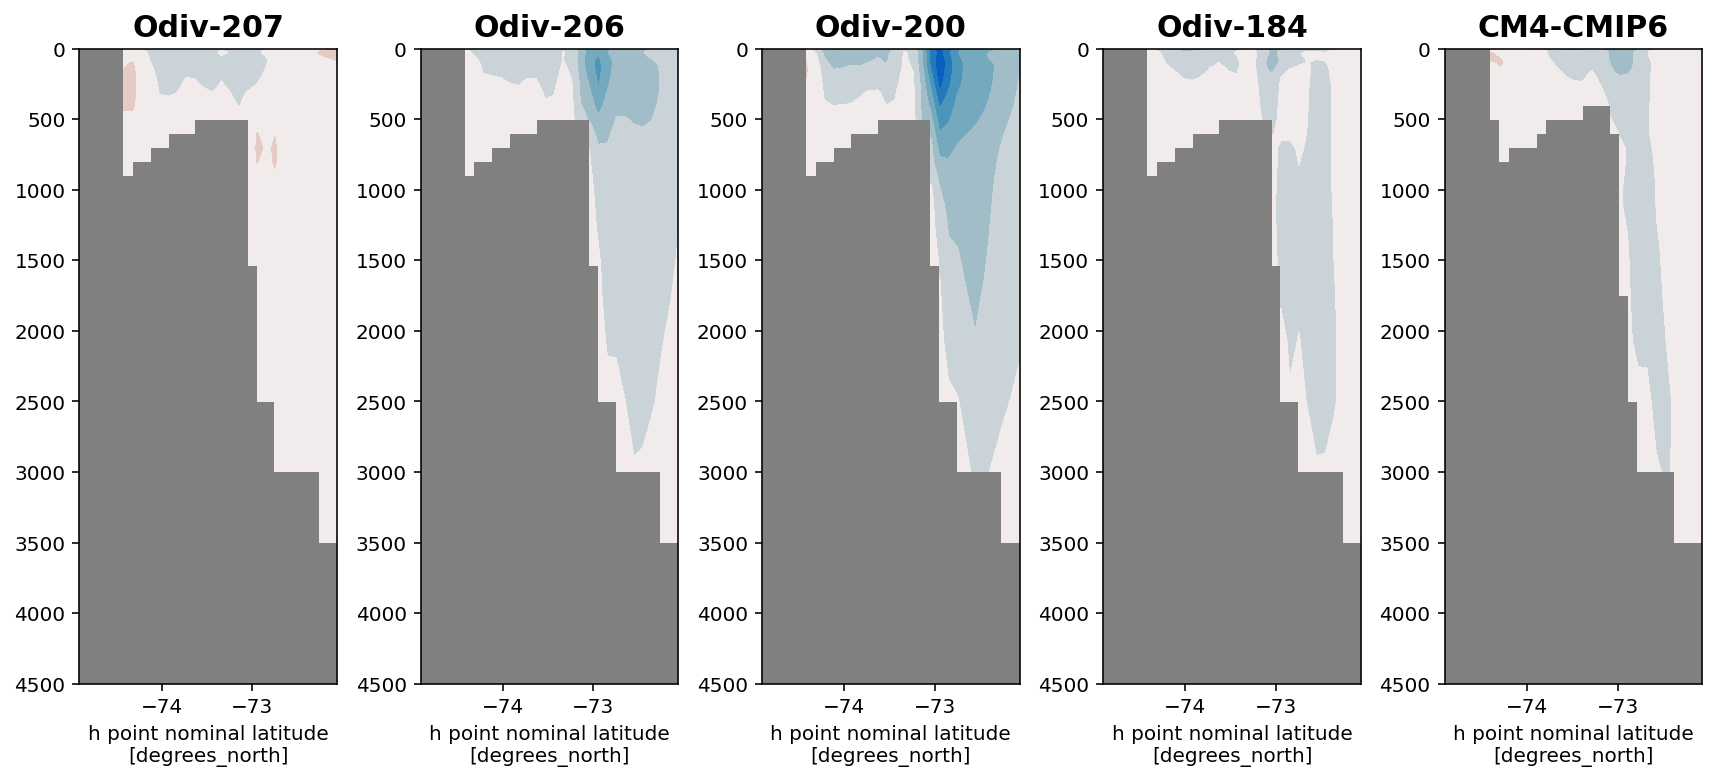

In [36]:
### Velocity at all cross-sections:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(12,5),subplot_kw=dict(facecolor='grey'))
plt.tight_layout()


levels_vel = np.linspace(-0.16,0.16,20)

odiv_207_u.uo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax1,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_206_u.uo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax2,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_200_u.uo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax3,
                                                                                                                add_colorbar=False, corner_mask=False)                                
odiv_183_184_u.uo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax4,
                                                                                                                add_colorbar=False, corner_mask=False)                                                                                                               
cm4_cmip6_u.uo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax5,
                                                                                                                add_colorbar=False, corner_mask=False)
ax1.set_title("Odiv-207",fontsize=15, fontweight='bold')
ax2.set_title("Odiv-206",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-200",fontsize=15, fontweight='bold')
ax4.set_title("Odiv-184",fontsize=15, fontweight='bold')
ax5.set_title("CM4-CMIP6",fontsize=15, fontweight='bold')

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Fl

Text(635.1517241379311, 0.5, '')

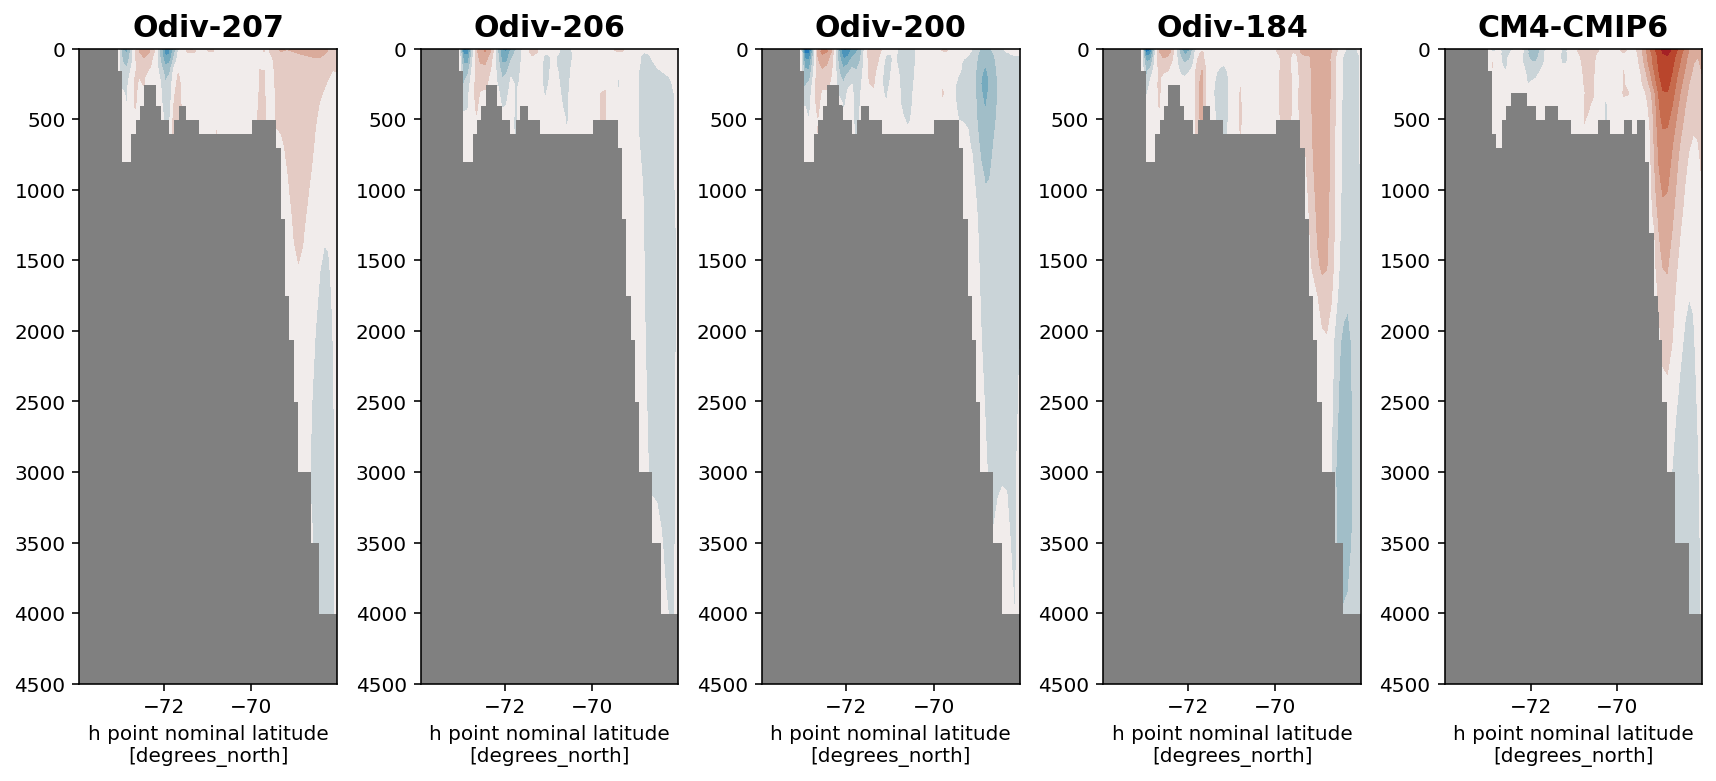

In [41]:
### Velocity at all cross-sections:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(12,5),subplot_kw=dict(facecolor='grey'))
plt.tight_layout()


levels_vel = np.linspace(-0.16,0.16,20)

odiv_207_u.uo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax1,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_206_u.uo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax2,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_200_u.uo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax3,
                                                                                                                add_colorbar=False, corner_mask=False)
odiv_183_184_u.uo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax4,
                                                                                                                add_colorbar=False, corner_mask=False)
cm4_cmip6_u.uo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sel(time=slice('0191-07-02','0200-07-02')).mean(dim='time').plot.contourf(yincrease=False,ylim=(4500,0),
                                                                                                                vmax=0.20,vmin=-0.20,
                                                                                                                cmap=cmocean.cm.balance,
                                                                                                                levels=20,ax=ax5,
                                                                                                                add_colorbar=False, corner_mask=False)                                
ax1.set_title("Odiv-207",fontsize=15, fontweight='bold')
ax2.set_title("Odiv-206",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-200",fontsize=15, fontweight='bold')
ax4.set_title("Odiv-184",fontsize=15, fontweight='bold')
ax5.set_title("CM4-CMIP6",fontsize=15, fontweight='bold')

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")                                              

In [44]:
client.close()
cluster.close()